# Testing DAG search

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import utils
import sympy
import config
import dag_search
import pickle

In [34]:
import importlib
importlib.reload(config)
importlib.reload(dag_search)
importlib.reload(utils)

<module 'utils' from 'C:\\Users\\Paul Kahlmeyer\\OneDrive\\PhD\\DAG_search\\utils.py'>

## Multiprocessing + Early Stopping

In [13]:
ds_name = 'Nguyen'
load_path = f'datasets/{ds_name}/tasks.p'

with open(load_path, 'rb') as handle:
    task_dict = pickle.load(handle)
problems = list(task_dict.keys())
problem = problems[0]

X, y, exprs_true = task_dict[problem]['X'], task_dict[problem]['y'], task_dict[problem]['expr']

In [16]:
loss_fkt = dag_search.MSE_loss_fkt(y)
params = {
    'X' : X,
    'n_outps' : y.shape[1],
    'loss_fkt' : loss_fkt,
    'k' : 1,
    'n_calc_nodes' : 5,
    'n_processes' : 2,
    'topk' : 5,
    'opt_mode' : 'grid_zoom',
    'verbose' : 2,
    'n_samples' : 1000,
    'stop_thresh' : 0.1

}
res = dag_search.sample_search(**params)

Generating graphs


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1425.15it/s]


Evaluating graphs


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.43it/s]


In [17]:
res['losses']

[0.054071606992498945,
 0.13492392820934337,
 0.18450594469973863,
 0.18450594469973866,
 0.18451075623071925]

In [41]:
loss_fkt = dag_search.MSE_loss_fkt(y)
params = {
    'X' : X,
    'n_outps' : y.shape[1],
    'loss_fkt' : loss_fkt,
    'k' : 1,
    'n_calc_nodes' : 3,
    'n_processes' : 2,
    'topk' : 5,
    'opt_mode' : 'grid_zoom',
    'verbose' : 2,
    'max_orders' : 1000, 
    'stop_thresh' : 0.1
}
res = dag_search.exhaustive_search(**params)

Creating evaluation orders


  2%|█▋                                                                       | 1000/43200 [00:00<00:00, 167097.09it/s]


Total orders: 114
Evaluating orders


100%|████████████████████████████████████████████████████████████████████████████████| 114/114 [00:05<00:00, 19.09it/s]


In [42]:
res['losses']

[0.016976529478039126,
 0.017138397889818816,
 0.11436630666254352,
 0.15112813657224833,
 0.18450414451763059]

## Evaluating results

In [297]:
ds_name = 'Feynman' # Strogatz, Feynman, Nguyen
mode = 'exhaustive' # exhaustive, sampling

with open(f'datasets/{ds_name}/{mode}_results.p', 'rb') as handle:
    results_dict = pickle.load(handle)
    
load_path = f'datasets/{ds_name}/tasks.p'
with open(load_path, 'rb') as handle:
    task_dict = pickle.load(handle)

In [298]:
# absolute recovery

total_rec = 0.0
for problem in results_dict:
    rec = results_dict[problem]['recovery']
    print(problem, rec)
    total_rec += np.mean(rec)
total_rec /= len(results_dict)
print(f'Recovery: {total_rec}')

I.10.7 [False]
I.11.19 [False]
I.12.1 [True]
I.12.11 [False]
I.12.2 [True]
I.12.4 [True]
I.12.5 [True]
I.13.12 [False]
I.13.4 [False]
I.14.3 [True]
I.14.4 [True]
I.15.3t [False]
I.15.3x [False]
I.16.6 [False]
I.18.12 [False]
I.18.14 [False]
I.18.4 [False]
I.24.6 [False]
I.25.13 [True]
I.27.6 [True]
I.29.16 [False]
I.29.4 [True]
I.30.3 [False]
I.32.17 [False]
I.32.5 [False]
I.34.1 [True]
I.34.14 [False]
I.34.27 [True]
I.34.8 [True]
I.37.4 [False]
I.38.12 [False]
I.39.1 [True]
I.39.11 [True]
I.39.22 [True]
I.40.1 [False]
I.41.16 [False]
I.43.16 [True]
I.43.31 [True]
I.43.43 [True]
I.44.4 [False]
I.47.23 [True]
I.50.26 [False]
I.6.2 [False]
I.6.2a [True]
I.6.2b [False]
I.8.14 [False]
I.9.18 [False]
II.10.9 [True]
II.11.20 [False]
II.11.27 [False]
II.11.28 [False]
II.11.3 [False]
II.13.17 [True]
II.13.23 [False]
II.13.34 [False]
II.15.4 [True]
II.15.5 [True]
II.2.42 [True]
II.21.32 [False]
II.24.17 [False]
II.27.16 [True]
II.27.18 [True]
II.3.24 [True]
II.34.11 [True]
II.34.2 [True]
Recove

In [299]:
with open(f'datasets/{ds_name}/{mode}_results_old.p', 'rb') as handle:
    results_old_dict = pickle.load(handle)

In [300]:
len(task_dict), len(results_dict), len(results_old_dict)

(95, 65, 95)

In [301]:
for problem in results_dict:
    v1 = results_dict[problem]['recovery'][0]
    v2 = results_old_dict[problem]['recovery'][0]
    if v1 != v2:
        print(f'Problem: {problem}, Old: {v2}, New: {v1}')

Problem: I.12.2, Old: False, New: True
Problem: I.43.43, Old: False, New: True
Problem: II.13.17, Old: False, New: True
Problem: II.2.42, Old: False, New: True


In [302]:
def r2score(y, pred):
    v1 = np.sum((pred - y)**2)
    v2 = np.sum((y - np.mean(y))**2)
    return 1 - v1/v2
    

In [303]:
total_rec = 0.0
for problem in results_dict:
    X, y, expr_true = task_dict[problem]['X'], task_dict[problem]['y'], task_dict[problem]['expr']
    graphs = results_dict[problem]['graphs']
    consts = results_dict[problem]['consts']

    
    rec = []
    r2s = []
    for i in range(len(graphs)):
        graph = graphs[i]
        c = consts[i]
        pred = graph.evaluate(X, c = c)[:, 0]
        y_part = y[:, i]
        r2 = r2score(y_part, pred)
        r2s.append(r2)
        rec.append(r2 > 0.999)
        
    print(problem, r2s)
    total_rec += np.mean(rec)
        
total_rec /= len(results_dict)
print(f'Recovery: {total_rec}')

I.10.7 [0.9999508837667627]
I.11.19 [0.6479236725870701]
I.12.1 [1.0]
I.12.11 [0.7430501590201715]
I.12.2 [0.9999605636894895]
I.12.4 [0.9999578196263461]
I.12.5 [1.0]
I.13.12 [0.8225405469124929]
I.13.4 [0.9410362980658785]
I.14.3 [1.0]
I.14.4 [1.0]
I.15.3t [0.9956593294532932]
I.15.3x [0.9944882158664714]
I.16.6 [0.9513972889320094]
I.18.12 [1.0]
I.18.14 [1.0]
I.18.4 [0.9255431446452905]
I.24.6 [0.9766358495233701]
I.25.13 [1.0]
I.27.6 [1.0]
I.29.16 [0.4710079531942384]
I.29.4 [1.0]
I.30.3 [0.48873885306487563]
I.32.17 [0.7336383361828771]
I.32.5 [0.8857831202167123]
I.34.1 [1.0]
I.34.14 [0.9998225780988027]
I.34.27 [0.9999999424261107]
I.34.8 [1.0]
I.37.4 [0.9946777639898998]
I.38.12 [0.9164223933547623]
I.39.1 [1.0]
I.39.11 [1.0]
I.39.22 [1.0]
I.40.1 [0.737292984603048]
I.41.16 [0.8622663234770133]
I.43.16 [1.0]
I.43.31 [1.0]
I.43.43 [1.0]
I.44.4 [0.94709468659005]
I.47.23 [1.0]
I.50.26 [0.5548397416982958]
I.6.2 [0.9660436805255608]
I.6.2a [0.9999840564898157]
I.6.2b [0.8425537485

In [266]:
problem = 'I.40.1'

idx = 0
X, y, expr_true = task_dict[problem]['X'], task_dict[problem]['y'], task_dict[problem]['expr']
graph = results_dict[problem]['graphs'][idx]
consts = results_dict[problem]['consts'][idx]

MSE: 0.09561265084539312


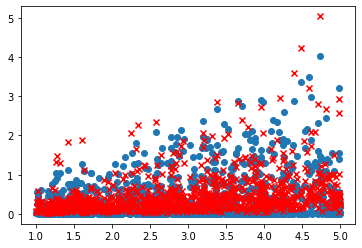

In [267]:
pred = graph.evaluate(X, c = consts)
mse = np.mean((pred[:, 0] - y[:, idx])**2)
print(f'MSE: {mse}')

plt.scatter(X[:, 0], y[:, idx])
plt.scatter(X[:, 0], pred[:, 0], marker = 'x', color = 'red')